In [111]:
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import argrelextrema


In [155]:
%matplotlib notebook

In [12]:
folder_marker = Path(r"R:\AG-Beste-Studien\Tracking Task\pilot_EEG\raw")

In [21]:
all_marker_files = [f for f in os.listdir(folder_marker) if f.endswith(".vmrk")]

In [22]:
marker_files = []
for f in all_marker_files:
    for i in range(7,11):
        if f"Pilot{i}" in f:
            marker_files.append(f)

In [23]:
marker_files

['Pilot10_A.vmrk',
 'Pilot10_B.vmrk',
 'Pilot10_C.vmrk',
 'Pilot7_A.vmrk',
 'Pilot7_B.vmrk',
 'Pilot7_C.vmrk',
 'Pilot8_A.vmrk',
 'Pilot8_B.vmrk',
 'Pilot8_C.vmrk',
 'Pilot9_A.vmrk',
 'Pilot9_B.vmrk',
 'Pilot9_C.vmrk']

In [80]:
# test: open one file
marker_fname = marker_files[0]
df = pd.read_csv(folder_marker/marker_fname, skiprows=11, header=None)
df

,0,1,2,3,4,5
0,Mk1=New Segment,NaN,1,1,0,20210603145505108548
1,Mk2=Stimulus,S 11,2974,1,0,NaN
2,Mk3=Stimulus,S 12,2986,1,0,NaN
3,Mk4=Stimulus,S 13,3174,1,0,NaN
4,Mk5=Stimulus,S 26,4374,1,0,NaN
...,...,...,...,...,...,...
373,Mk374=Stimulus,S 23,586331,1,0,NaN
374,Mk375=Stimulus,S 24,588164,1,0,NaN
375,Mk376=Stimulus,S 16,590240,1,0,NaN
376,Mk377=Stimulus,S 17,607421,1,0,NaN


In [37]:
# restrict to start and end trigger
df_starts_ends = df[df[1].isin(["S 27", "S 12", "S 16"])]

In [46]:
df_starts_ends[1][:40]

2      S 12
5      S 27
8      S 12
11     S 27
14     S 12
17     S 27
20     S 12
23     S 27
26     S 12
29     S 27
32     S 12
35     S 27
38     S 12
41     S 27
44     S 12
47     S 27
50     S 12
53     S 27
56     S 12
59     S 27
62     S 16
64     S 12
67     S 27
70     S 12
73     S 27
76     S 12
79     S 27
82     S 12
85     S 27
88     S 12
91     S 27
94     S 12
97     S 27
100    S 12
103    S 27
106    S 12
109    S 27
112    S 12
115    S 27
118    S 12
Name: 1, dtype: object

In [58]:
start_trials_samp = []
dur_trials_in_samp = []

In [49]:
df_starts_ends

,0,1,2,3,4,5
2,Mk3=Stimulus,S 12,2986,1,0,NaN
5,Mk6=Stimulus,S 27,5207,1,0,NaN
8,Mk9=Stimulus,S 12,11765,1,0,NaN
11,Mk12=Stimulus,S 27,14049,1,0,NaN
14,Mk15=Stimulus,S 12,20548,1,0,NaN
...,...,...,...,...,...,...
363,Mk364=Stimulus,S 12,575020,1,0,NaN
366,Mk367=Stimulus,S 27,577272,1,0,NaN
369,Mk370=Stimulus,S 12,582579,1,0,NaN
372,Mk373=Stimulus,S 27,584814,1,0,NaN


In [59]:
for i in range(len(df_starts_ends)):
    if i == 0:
        continue
    if df_starts_ends[1].tolist()[i] == "S 27":
        start_trials_samp.append(df_starts_ends[2].tolist()[i])
    elif df_starts_ends[1].tolist()[i - 1] == "S 27":
        dur_trials_in_samp.append(df_starts_ends[2].tolist()[i] - df_starts_ends[2].tolist()[i - 1])

In [34]:
# old version
"""
relevant_samples = df_starts_ends[2].tolist()[1:]

for i, samp in enumerate(relevant_samples):
    if i%2 == 0:
        start_trials_samp.append(samp)
    else:
        dur_trials_in_samp.append(samp - relevant_samples[i - 1])
"""

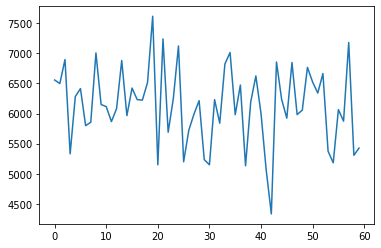

In [62]:
plt.plot(dur_trials_in_samp)

In [69]:
# read the behavioral files

path_behav = Path(r"R:\AG-Beste-Studien\Tracking Task\pilot_behav\data")

In [76]:
all_subdirs = [f.name for f in os.scandir(path_behav) if f.is_dir()]

In [77]:
subdirs = []
for d in all_subdirs:
    for i in range(7,11):
        if f"Pilot{i}" in d:
            subdirs.append(d)

In [79]:
subdirs

['Pilot10-A-2021-06-07',
 'Pilot10-C-2021-06-07',
 'Pilot7-A-2021-06-07',
 'Pilot7-B-2021-06-07',
 'Pilot7-C-2021-06-07',
 'Pilot8-A-2021-06-07',
 'Pilot8-C-2021-06-07',
 'Pilot9-A-2021-06-07',
 'Pilot9-C-2021-06-07']

In [83]:
# find the equivalent behavioral file:
behavioral_folder = [f for f in subdirs if f.split("-")[0] == marker_fname.split("_")[0]][0]
behavioral_folder

'Pilot10-A-2021-06-07'

In [89]:
# sanity test
len(os.listdir(path_behav/behavioral_folder)) - 1 == len(dur_trials_in_samp)

True

In [90]:
def load_trial(foldername, trialnum):
    # trialnum should start at 1
    all_files = os.listdir(path_behav/foldername)
    filename = [f for f in all_files if f.split("_")[-1].split(".")[0] == str(trialnum)][0]
    return pd.read_csv(path_behav/foldername/filename)

In [136]:
# test
trial_df = load_trial(behavioral_folder, 1)
#trial_df = trial_df.sort_values("error_abs", ascending=False)
trial_df["error_abs"]

0      0.000015
1      0.006376
2      0.012899
3      0.019447
4      0.026014
         ...   
781    0.076783
782    0.078607
783    0.075318
784    0.073887
785    0.072456
Name: error_abs, Length: 786, dtype: float64

In [172]:
trial_df.columns

Index(['traj-x', 'traj-y', 'purs-x', 'purs-y', 'error', 'error_abs'], dtype='object')

In [137]:
# find the samples with peaks

trial_abs_errors = np.array(trial_df["error_abs"].tolist())
#argrelextrema(trial_abs_errors, np.greater)

In [170]:
local_max = []
ascending = False
ascend_counter = 0
descend_counter = 0

min_samp_dist = 10

for i, err_val in enumerate(trial_abs_errors[:-1]):
    
    # if ascending and previously descending, reset counter
    if trial_abs_errors[i + 1] > trial_abs_errors[i] and not ascending:
        ascending = True
    # if ascending already true, increment counter
    elif trial_abs_errors[i + 1] > trial_abs_errors[i]:
        ascend_counter += 1
        
    # if descending and previously ascending, reset counter
    if trial_abs_errors[i + 1] < trial_abs_errors[i] and ascending:
        ascending = False
        # "lose" the progress if not minimum number of ascends --> reset
        if ascend_counter < min_samp_dist:
            ascend_counter = 1
    # if descending already true, increment counter
    # but only if it is a viable candidate
    elif trial_abs_errors[i + 1] < trial_abs_errors[i]:
        descend_counter += 1
        
    # check descending
    if ascend_counter >= min_samp_dist and descend_counter >= min_samp_dist:
        local_max.append(i - descend_counter)
        ascend_counter = 1
        descend_counter = 1
    elif ascending:
        descend_counter = 1

<IPython.core.display.Javascript object>


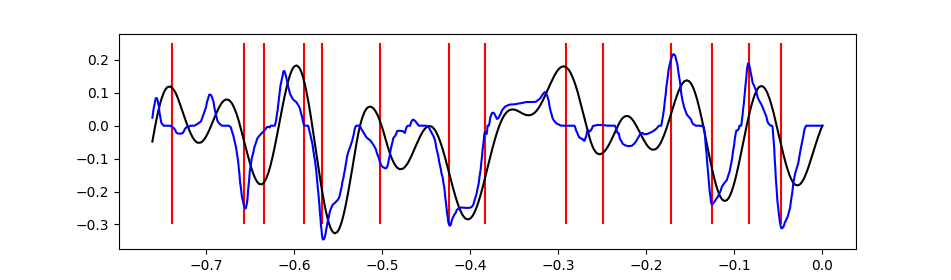

In [177]:
#plt.plot(trial_abs_errors)
plt.plot(trial_df["traj-x"].tolist(), trial_df["traj-y"].tolist(), "black")
plt.plot(trial_df["purs-x"].tolist(), trial_df["purs-y"].tolist(), "blue")
plt.vlines([trial_df["traj-x"].tolist()[v] for v in local_max], -0.3, 0.25, "red")
plt.show()

In [152]:
local_max

[23,
 28,
 48,
 53,
 70,
 75,
 90,
 95,
 116,
 121,
 145,
 153,
 183,
 188,
 201,
 206,
 219,
 235,
 240,
 255,
 260,
 297,
 302,
 322,
 327,
 360,
 368,
 403,
 408,
 447,
 452,
 470,
 475,
 520,
 529,
 556,
 571,
 607,
 612,
 637,
 642,
 668,
 673,
 690,
 698,
 724,
 729,
 758,
 763,
 781]

In [138]:
# on a sidenote: how many behavioral samples per EEG sample?
len(trial_abs_errors)

786

In [139]:
dur_trials_in_samp[0]

6558

In [135]:
651/5426

0.11997788426096571

In [140]:
786/6558

0.11985361390667887

In [141]:
# factor of 0.12 --> ascending/descending samples at least 256 (EEG SR) * 0.1 (100 ms) * 0.12 (factor)
256*0.1*0.12

3.072